#### Predicting Air Conditioning On/Off Status Using LSTM Neural Network

## Introduction

In this notebook, we will develop a Long Short-Term Memory (LSTM) neural network to predict whether the air conditioning can remain on for more than X minutes. This prediction is based on the energy production and consumption data of a residential building. The aim is to ensure that during the following X minutes, the production of energy is greater than the consumption.

## Table of Contents

1. [Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)
2. [Data Preprocessing](#2.-Data-Preprocessing)
3. [Feature Engineering](#3.-Feature-Engineering)
4. [Train-Test Split](#4.-Train-Test-Split)
5. [Building the LSTM Model](#5.-Building-the-LSTM-Model)
6. [Model Training](#6.-Model-Training)
7. [Model Evaluation](#7.-Model-Evaluation)

## 1. Exploratory Data Analysis

In this section, we will load and explore the dataset to understand its structure and the types of features available.

### Actions:
1. Load the dataset
2. Inspect the data for missing values and data types
3. Visualize key metrics such as energy production and consumption over time


In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm


In [59]:
# Load the dataset
data = pd.read_csv('./data/household_data_1min_singleindex.csv', low_memory=False)

data['cet_cest_timestamp'] = pd.to_datetime(data['cet_cest_timestamp'], utc=True)

first_valid_index = data['DE_KN_residential2_grid_import'].first_valid_index()
last_valid_index = data['DE_KN_residential2_grid_import'].last_valid_index()

data = data.loc[first_valid_index:last_valid_index]

data = data[[
    'cet_cest_timestamp', 
    'DE_KN_residential2_circulation_pump', 
    'DE_KN_residential2_dishwasher', 
    'DE_KN_residential2_freezer', 
    'DE_KN_residential2_grid_import',
    'DE_KN_residential2_washing_machine',
    'DE_KN_residential1_pv'
]]


In [3]:
# Inspect the first few rows of the dataset
print(data.head())

# Check for missing values
print(data.isnull().sum()) 

# Basic statistics
print(data.describe())

              cet_cest_timestamp  DE_KN_residential2_circulation_pump  \
179489 2015-04-15 09:28:00+00:00                               19.771   
179490 2015-04-15 09:29:00+00:00                               19.771   
179491 2015-04-15 09:30:00+00:00                               19.771   
179492 2015-04-15 09:31:00+00:00                               19.771   
179493 2015-04-15 09:32:00+00:00                               19.771   

        DE_KN_residential2_dishwasher  DE_KN_residential2_freezer  \
179489                          2.764                       1.535   
179490                          2.764                       1.535   
179491                          2.764                       1.535   
179492                          2.764                       1.535   
179493                          2.764                       1.535   

        DE_KN_residential2_grid_import  DE_KN_residential2_washing_machine  \
179489                           0.000                              

In [60]:
data['residential2_circulation_pump'] = data['DE_KN_residential2_circulation_pump'].diff().fillna(0)
data['residential2_dishwasher'] = data['DE_KN_residential2_dishwasher'].diff().fillna(0)
data['residential2_freezer'] = data['DE_KN_residential2_freezer'].diff().fillna(0)
data['residential2_washing_machine'] = data['DE_KN_residential2_washing_machine'].diff().fillna(0)

data['total_consumption'] = data['DE_KN_residential2_grid_import'].diff().fillna(0)

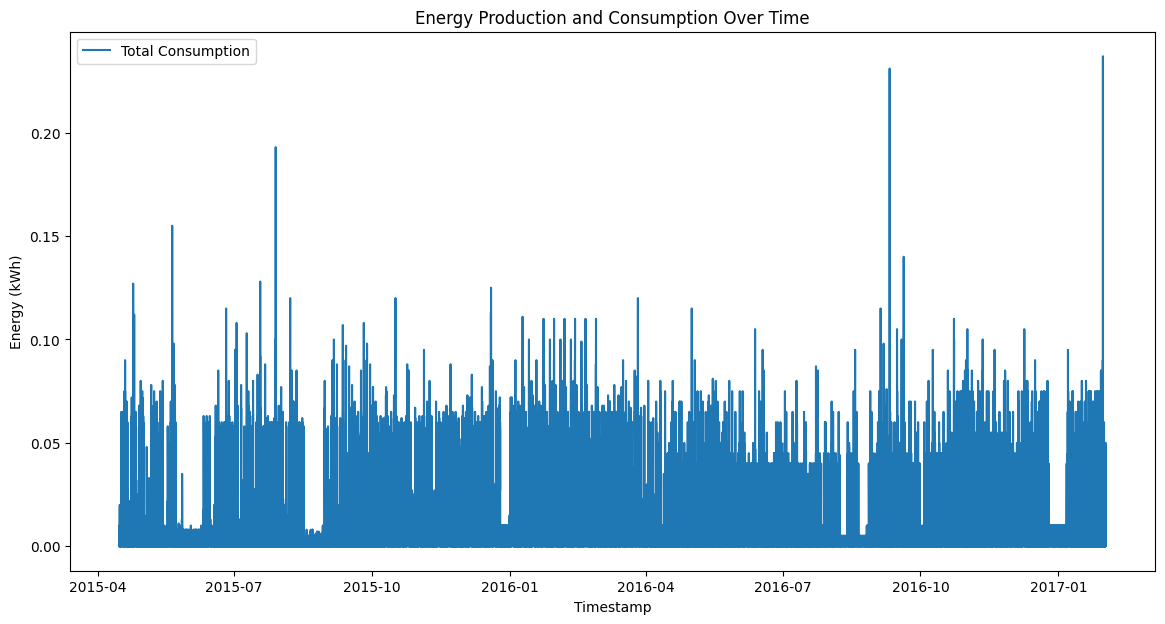

In [61]:
# Visualize energy production and consumption
plt.figure(figsize=(14, 7))
sns.lineplot(x='cet_cest_timestamp', y='total_consumption', data=data, label='Total Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Energy (kWh)')
plt.title('Energy Production and Consumption Over Time')
plt.legend()
plt.show()

## 2. Data Preprocessing
Before training our model, we need to preprocess the data. This includes handling missing values, creating a target variable, and scaling the features.

### Actions:
- Handle missing values
- Create a target variable indicating if the air conditioning can stay on for more than X minutes
- Scale the features using StandardScaler

In [141]:
pv_data = pd.read_csv('./data/time_series_kai_power.csv')

# Asegurarse de que la columna de tiempo está en formato datetime
pv_data['time'] = pd.to_datetime(pv_data['time'], utc=True)

# Configurar la columna de tiempo como el índice
pv_data = pv_data.set_index('time')

# Asegurarse de que el índice de tiempo no tenga duplicados y esté ordenado
pv_data = pv_data[~pv_data.index.duplicated(keep='first')]
pv_data = pv_data.sort_index()

pv_data['hour_sin'] = np.sin(2 * np.pi * pv_data.index.hour / 24)
pv_data['dayofyear_sin'] = np.sin(2 * np.pi * pv_data.index.dayofyear / 365.25)

In [142]:
def calculate_minute_mean(pv_data, target_date, days=3):
    means = []
    expected_length = None  # Para asegurar longitudes uniformes
    
    for i in range(1, days + 1):
        prev_date = target_date - timedelta(days=i)
        next_date = target_date + timedelta(days=i)
        
        prev_day_data = pv_data[pv_data.index.date == prev_date.date()]
        next_day_data = pv_data[pv_data.index.date == next_date.date()]
        
        if not prev_day_data.empty:
            if expected_length is None:
                expected_length = len(prev_day_data)
            if len(prev_day_data) == expected_length:
                means.append(prev_day_data['value'].values)
        
        if not next_day_data.empty:
            if expected_length is None:
                expected_length = len(next_day_data)
            if len(next_day_data) == expected_length:
                means.append(next_day_data['value'].values)
    
    if len(means) > 0:
        means = np.array(means)
        minute_means = np.nanmean(means, axis=0)
        return minute_means
    else:
        return None

In [143]:
# Identificar los días con picos de más de 70 W
threshold = 70
pv_data['diff'] = pv_data['value'].diff()
spike_days = pv_data[pv_data['diff'] > threshold].index.floor('D').unique()

# Reemplazar los valores en los días con picos
for spike_day in spike_days:
    minute_means = calculate_minute_mean(pv_data, spike_day, days=3)
    if minute_means is not None:
        spike_day_data = pv_data[pv_data.index.date == spike_day.date()]
        if len(spike_day_data) == len(minute_means):
            pv_data.loc[spike_day_data.index, 'value'] = minute_means
        else:
            # Si hay discrepancias en el número de datos, usar interpolación para ajustar
            interpolated_means = np.interp(np.arange(len(spike_day_data)), np.linspace(0, len(spike_day_data) - 1, len(minute_means)), minute_means)
            pv_data.loc[spike_day_data.index, 'value'] = interpolated_means

# Eliminar la columna 'diff' ya que no es necesaria después del procesamiento
pv_data.drop(columns=['diff'], inplace=True)
pv_data.dropna(inplace=True)

In [144]:
# Resampling to 1 minute granularity
pv_data_resampled = pv_data.resample('min').interpolate(method='linear')

# Reiniciar el índice
pv_data_resampled = pv_data_resampled.dropna().reset_index()
pv_data_resampled.head()

,time,value,hour_sin,dayofyear_sin
0,2024-05-10 17:24:00+00:00,1.393,-0.965926,0.775859
1,2024-05-10 17:25:00+00:00,1.355,-0.965926,0.775859
2,2024-05-10 17:26:00+00:00,1.317,-0.965926,0.775859
3,2024-05-10 17:27:00+00:00,1.279,-0.965926,0.775859
4,2024-05-10 17:28:00+00:00,1.241,-0.965926,0.775859


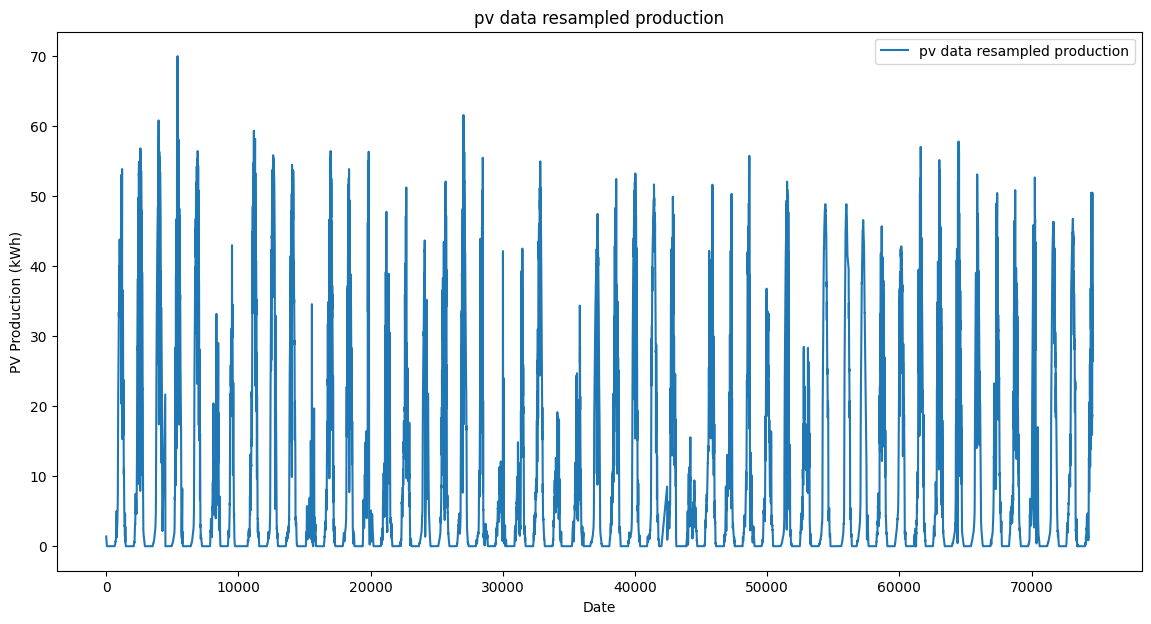

In [145]:
plt.figure(figsize=(14, 7))
plt.plot(pv_data_resampled.index, pv_data_resampled['value'], label='pv data resampled production')
plt.xlabel('Date')
plt.ylabel('PV Production (kWh)')
plt.title('pv data resampled production')
plt.legend()
plt.show()

In [146]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
pv_data['value'] = scaler.fit_transform(pv_data['value'].values.reshape(-1, 1))

# Crear secuencias de datos para entrenar el LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence_data = data[i:i+seq_length]
        sequences.append(sequence_data)
    return np.array(sequences)

seq_length = int(60*24/5)  # Usar las últimas 24 horas para predecir la producción de energía en el siguiente minuto
data_values = pv_data[['value', 'hour_sin', 'dayofyear_sin']].values
data_sequences = create_sequences(data_values, seq_length)

X = data_sequences[:, :-1]
y = data_sequences[:, -1][:, 0]  # Solo necesitamos predecir el valor 'value'

# Reshape de los datos para LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Dividir en conjuntos de entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Crear el modelo LSTM

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


In [147]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - loss: 0.0137 - val_loss: 0.0041
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - loss: 0.0060 - val_loss: 0.0034
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - loss: 0.0051 - val_loss: 0.0034
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 12/20
143/143

In [149]:
# Hacer predicciones
predictions = model.predict(X_test)

# Invertir la normalización
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step



Predicted PV DataFrame:
                           predicted_value
timestamp                                 
2024-06-21 15:21:00+00:00        17.228907
2024-06-21 15:26:00+00:00        16.155556
2024-06-21 15:31:00+00:00        16.577141
2024-06-21 15:36:00+00:00        15.435906
2024-06-21 15:41:00+00:00        14.787035
...                                    ...
2024-07-01 12:41:00+00:00        19.109434
2024-07-01 12:46:00+00:00        26.488003
2024-07-01 12:51:00+00:00        28.257177
2024-07-01 12:56:00+00:00        38.943459
2024-07-01 13:00:00+00:00        27.884459

[2854 rows x 1 columns]


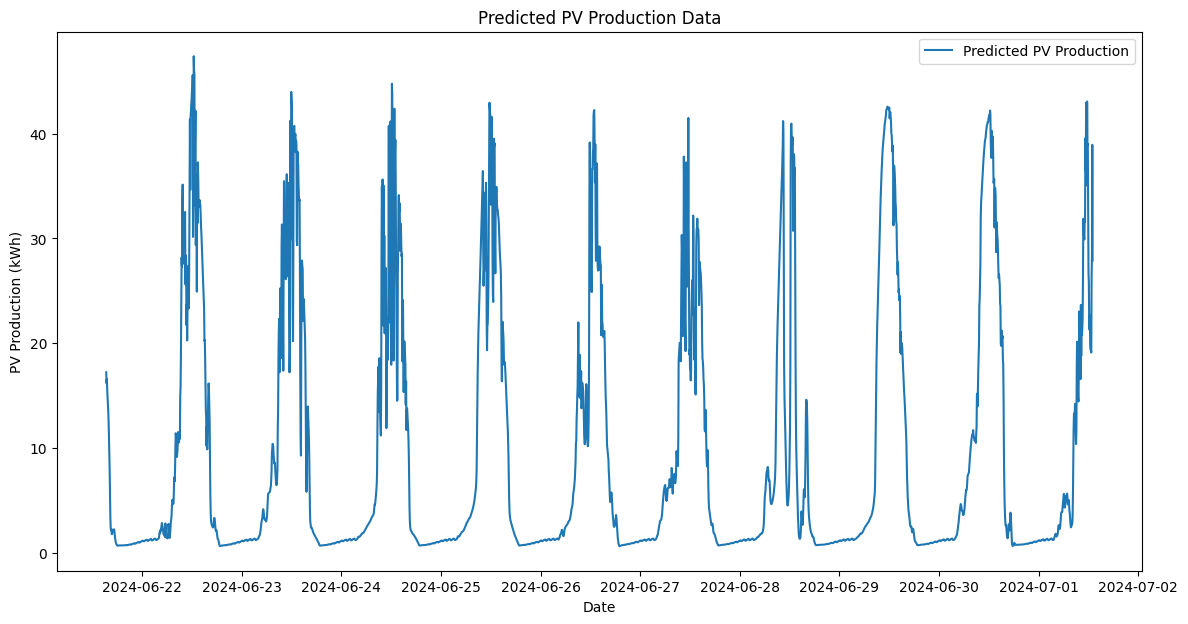

In [150]:
# Crear un DataFrame con las predicciones
dates_test = pv_data.index[split + seq_length:]
df_predictions = pd.DataFrame({'timestamp': dates_test, 'predicted_value': predictions.flatten()})
df_predictions.set_index('timestamp', inplace=True)

# Mostrar el DataFrame de datos predichos
print("\nPredicted PV DataFrame:")
print(df_predictions)

# Graficar los datos predichos
plt.figure(figsize=(14, 7))
plt.plot(df_predictions.index, df_predictions['predicted_value'], label='Predicted PV Production')
plt.xlabel('Date')
plt.ylabel('PV Production (kWh)')
plt.title('Predicted PV Production Data')
plt.legend()
plt.show()

In [161]:
# Generar datos sintéticos para el periodo deseado
start_date = data['cet_cest_timestamp'].min()
end_date = data['cet_cest_timestamp'].max()
dates_synthetic = pd.date_range(start=start_date, end=end_date, freq='5min')

# Crear un DataFrame con las fechas deseadas y características temporales sinusoidales
df_synthetic_dates = pd.DataFrame(index=dates_synthetic)
df_synthetic_dates['hour_sin'] = np.sin(2 * np.pi * df_synthetic_dates.index.hour / 24)
df_synthetic_dates['dayofyear_sin'] = np.sin(2 * np.pi * df_synthetic_dates.index.dayofyear / 365.25)


# Crear una secuencia inicial para iniciar la predicción
initial_sequence = pv_data[['value', 'hour_sin', 'dayofyear_sin']].values[:seq_length]
initial_sequence = initial_sequence.reshape(1, seq_length, initial_sequence.shape[1])


In [162]:
# Generar predicciones sintéticas
predictions = []
current_sequence = initial_sequence

for i in tqdm(range(len(dates_synthetic))):
    prediction = model.predict(current_sequence, verbose=0)
    predictions.append(prediction[0, 0])
    
    # Crear la nueva secuencia
    next_hour_sin = df_synthetic_dates['hour_sin'].iloc[i]
    next_dayofyear_sin = df_synthetic_dates['dayofyear_sin'].iloc[i]
    next_sequence = np.array([prediction[0, 0], next_hour_sin, next_dayofyear_sin])
    
    current_sequence = np.roll(current_sequence, -1, axis=1)
    current_sequence[0, -1] = next_sequence



 10%|█         | 19653/189565 [08:15<1:11:21, 39.68it/s]


KeyboardInterrupt: 

In [163]:
# Invertir la normalización
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


Synthetic PV DataFrame:
                           pv_production
timestamp                               
2015-04-15 09:28:00+00:00       1.157386
2015-04-15 09:33:00+00:00       1.277804
2015-04-15 09:38:00+00:00       0.712657
2015-04-15 09:43:00+00:00       0.102314
2015-04-15 09:48:00+00:00      -0.380466
...                                  ...
2015-06-22 14:48:00+00:00      13.538243
2015-06-22 14:53:00+00:00      13.116303
2015-06-22 14:58:00+00:00      12.717230
2015-06-22 15:03:00+00:00      12.342052
2015-06-22 15:08:00+00:00      11.922329

[19653 rows x 1 columns]


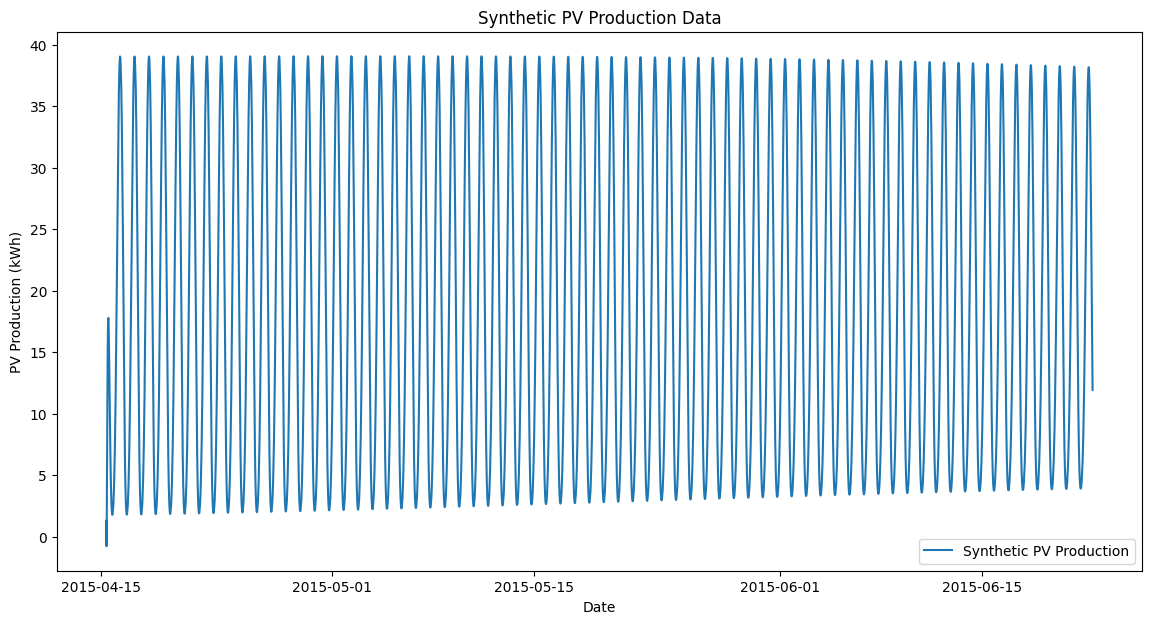

In [164]:
# Crear un DataFrame con los datos sintéticos
df_synthetic = pd.DataFrame({'timestamp': dates_synthetic[:len(predictions)], 'pv_production': predictions.flatten()})
df_synthetic.set_index('timestamp', inplace=True)

# Mostrar el DataFrame de datos sintéticos
print("\nSynthetic PV DataFrame:")
print(df_synthetic)

# Graficar los datos sintéticos
plt.figure(figsize=(14, 7))
plt.plot(df_synthetic.index, df_synthetic['pv_production'], label='Synthetic PV Production')
plt.xlabel('Date')
plt.ylabel('PV Production (kWh)')
plt.title('Synthetic PV Production Data')
plt.legend()
plt.show()

In [43]:


# Handle missing values
data = data.ffill()

# Extraer el mes del año y la hora del día del timestamp
data['month'] = data['cet_cest_timestamp'].dt.month
data['hour'] = data['cet_cest_timestamp'].dt.hour

# Aplicar la transformación sinusoidal al mes del año
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)

# Aplicar la transformación sinusoidal a la hora del día
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)

# Delete original columns 'Hour' and 'Month'
data.drop(['hour', 'month'], axis=1, inplace=True)

# Create target variable
X_minutes = 60 # Granularity is set to 1 min

# Initialize the air conditioning column with 0
data['air_conditioning_on'] = 0

# Set air conditioning on if production > consumption
data.loc[data['total_production'] > data['total_consumption'], 'air_conditioning_on'] = 1

# Shift the air conditioning state by one period to use the previous period's decision
data['air_conditioning_on'] = data['air_conditioning_on'].shift(1, fill_value=0)

data['target'] = data['air_conditioning_on'].rolling(window=X_minutes).sum().shift(-X_minutes) > X_minutes * 0.5

# Drop rows with NaN values in the target column
data = data.dropna(subset=['target'])

# Select relevant features for the model, including the new temporal features
features = [
    'DE_KN_residential2_circulation_pump', 
    'DE_KN_residential2_dishwasher', 
    'DE_KN_residential2_freezer', 
    'DE_KN_residential2_grid_import',
    'DE_KN_residential2_washing_machine',
    'DE_KN_residential1_pv',
    'month_sin',
    'hour_sin'
]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

# Prepare final DataFrame
final_data = pd.DataFrame(scaled_features, columns=features)
final_data['target'] = data['target'].values

KeyError: 'utc_timestamp'

## 3. Feature Engineering
We need to transform our data into sequences suitable for the LSTM model. LSTMs require input data in a specific 3D shape: (samples, time steps, features).

### Actions:
- Create sequences of data for LSTM input
- Define the function to create sequences

In [3]:

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        target = data.iloc[i + seq_length]['target']
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

seq_length = 60  # Define sequence length
X, y = create_sequences(final_data, seq_length)


## 4. Train-Test Split
To evaluate our model, we need to split the data into training and testing sets.

### Actions:
- Split the sequences into training and testing sets

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 5. Building the LSTM Model
Next, we will build the LSTM model using Keras. LSTM is a type of recurrent neural network (RNN) well-suited for time series data.

### Actions:
- Define the LSTM model architecture

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        18,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,851 (151.76 KB)

 Trainable params: 38,851 (151.76 KB)

 Non-trainable params: 0 (0.00 B)

None


## 6. Model Training
We will train the LSTM model using the training data.

### Actions:
- Train the model
- Plot the training history

Epoch 1/20
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 168s 15ms/step - accuracy: 0.9413 - loss: 0.1463 - val_accuracy: 0.9482 - val_loss: 0.1255
Epoch 2/20
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 174s 16ms/step - accuracy: 0.9479 - loss: 0.1254 - val_accuracy: 0.9487 - val_loss: 0.1217
Epoch 3/20
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 175s 16ms/step - accuracy: 0.9502 - loss: 0.1198 - val_accuracy: 0.9506 - val_loss: 0.1194
Epoch 4/20
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 175s 16ms/step - accuracy: 0.9509 - loss: 0.1184 - val_accuracy: 0.9517 - val_loss: 0.1155
Epoch 5/20
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 172s 15ms/step - accuracy: 0.9510 - loss: 0.1156 - val_accuracy: 0.9515 - val_loss: 0.1161
Epoch 6/20
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 177s 16ms/step - accuracy: 0.9521 - loss: 0.1138 - val_accuracy: 0.9523 - val_loss: 0.1139
Epoch 7/20
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 179s 16ms/step - accuracy: 0.9526 - loss: 0.1131 - val_accuracy: 0.9517 - val_loss: 0.1150
Epoch 8/20
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 183s 17ms/s

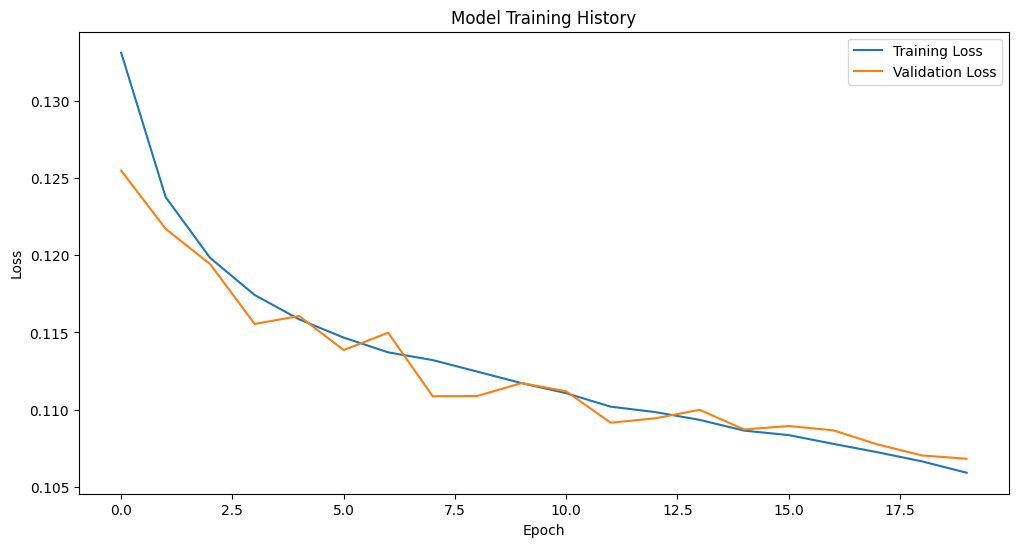

In [6]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training History')
plt.legend()
plt.show()

## 7. Model Evaluation
After training, we need to evaluate the model's performance on the test set.

### Actions:
- Evaluate the model on test data
- Calculate additional performance metrics

3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
              precision    recall  f1-score   support

       False       0.97      0.95      0.96     67334
        True       0.92      0.96      0.94     43749

    accuracy                           0.95    111083
   macro avg       0.95      0.95      0.95    111083
weighted avg       0.95      0.95      0.95    111083



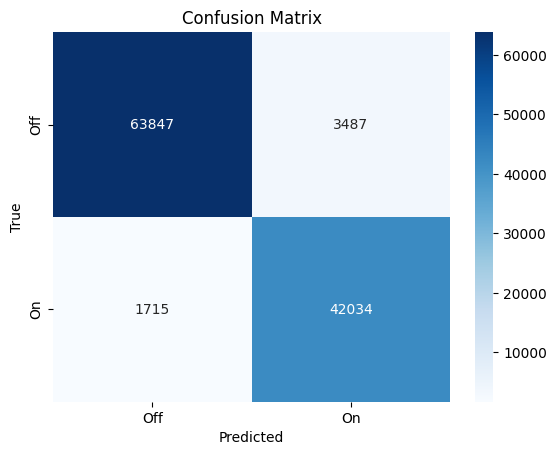

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Off', 'On'], yticklabels=['Off', 'On'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## 8. Comparing with other models

3472/3472 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
Baseline accuracy: 0.95
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3472/347

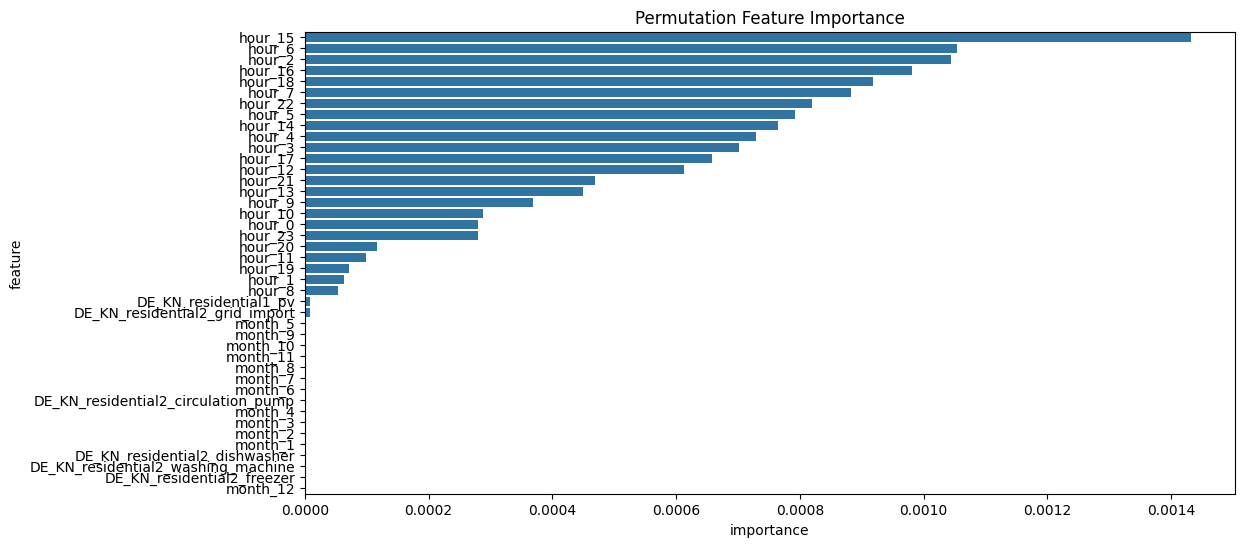

In [8]:
from sklearn.metrics import accuracy_score

def permute_feature(X, feature_idx):
    X_permuted = X.copy()
    for i in range(X_permuted.shape[0]):
        np.random.shuffle(X_permuted[i, :, feature_idx])
    return X_permuted

# Define a function to wrap the model's prediction method
def model_predict(X):
    return (model.predict(X) > 0.5).astype("int32")

# Evaluate the baseline accuracy on the test set
baseline_accuracy = accuracy_score(y_test, model_predict(X_test))
print(f"Baseline accuracy: {baseline_accuracy:.2f}")

# Calculate permutation feature importance
importance_scores = []

for i in range(X_test.shape[2]):
    X_permuted = permute_feature(X_test, i)
    permuted_accuracy = accuracy_score(y_test, model_predict(X_permuted))
    importance_score = baseline_accuracy - permuted_accuracy
    importance_scores.append(importance_score)

# Create a DataFrame to display the importance scores
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importance_scores
}).sort_values(by='importance', ascending=False)

print(importance_df)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Permutation Feature Importance')
plt.show()
